# SVM with Docking Scores

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [ ]:
from modules.plotting_metrics import PlotMetric

## Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [2]:
def open_results(path, column_to_drop, active_label='Active'):
    '''Function to load VS results from path file. It returns X and y ndarrays.'''
    path_file = os.path.join(*path.split('/'))
    df_results = pd.read_csv(path_file, index_col=0)
    y_ = pd.Series(df_results[column_to_drop] == active_label, dtype = int) # Setting y_true
    X_ = df_results.drop([column_to_drop], axis = 1) # Setting X
    return X_, y_

In [3]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = open_results(path = '../data/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [4]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = open_results(path = '../data/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

In [216]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

def run_SVM(X_train, X_test, y_train, y_test, 
            C = np.geomspace(0.01, 100, 5), kernel='linear', 
            scoring = roc_auc_scorer, extra_params_dict = None, **kwargs):
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()),
            ("SVC", SVC(probability=True, **kwargs))])
    params = {'SVC__C': C, 'SVC__kernel': [kernel]}
    if extra_params_dict != None:
        for key, value in extra_params_dict.items():
            params[key] = value
    # Grid search for turning the optimal parameters
    linear_SVC = GridSearchCV(SVCpipe, param_grid = params, 
                              scoring = scoring, iid = False, n_jobs = 4,
                              refit=True, cv = 5, return_train_score = True)
    # grid training
    linear_SVC.fit(X_train, y_train)
    # scaling and prediction of X_train using the bes model found by grid
    y_train_pred = linear_SVC.best_estimator_.predict(X_train)
    # scaling and prediction of X_train using the bes model found by grid
    y_pred  = linear_SVC.predict(X_test) # Predicted values for X_test
    y_score = linear_SVC.decision_function(X_test) # Hyperplane distances
    roc_auc = roc_auc_score(y_true = y_test, y_score = y_score)
    return(y_score, linear_SVC.best_estimator_, linear_SVC.cv_results_)

0.7849766955962714
0.767056412729026


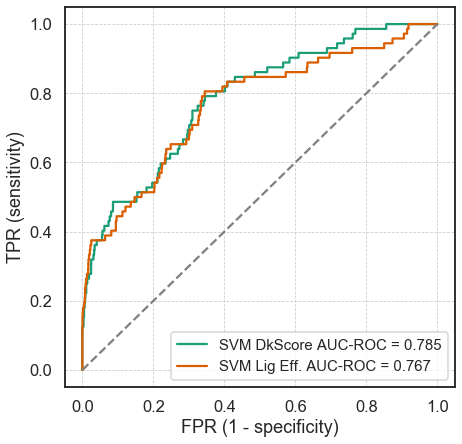

In [224]:
X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD
y_score_dksc, svc_dksc, svc_dkef_res = run_SVM(X_train, X_test, y_train, y_test)

X_train = X_dkef_CSAR; y_train = y_dkef_CSAR
X_test = X_dkef_DUD; y_test = y_dkef_DUD
y_score_dkef, svc_dkef, svc_dkef_res = run_SVM(X_train, X_test, y_train, y_test)

svm_preds = {'SVM DkScore': y_score_dksc, 'SVM Lig Eff.': y_score_dkef}
svm_rocs = PlotMetric(y_true = y_test, y_pred_dict = svm_preds,
                     decreasing = False)
svm_rocs.plot_roc_auc('')

In [242]:
y_pred = svc_dkef.predict_proba(X_dkef_DUD)[:,1] >= 0.091


roc_auc_score(y_true= y_test, y_score = y_pred)

0.7272715096967748

0.6837230793956927
0.6878951033965499


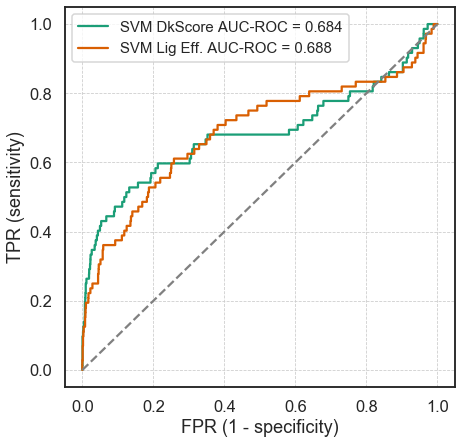

In [217]:
svc_params = {'SVC__gamma': [0.001, 0.01, 0.1, 1]}

X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD
y_score_dksc, svc_dksc, svc_dksc_res = run_SVM(X_train, X_test, y_train, y_test, kernel='poly',
                                 extra_params_dict = svc_params)

X_train = X_dkef_CSAR; y_train = y_dkef_CSAR
X_test = X_dkef_DUD; y_test = y_dkef_DUD
y_score_dkef, svc_dkef, svc_dkef_res = run_SVM(X_train, X_test, y_train, y_test, kernel='poly', 
                                 extra_params_dict = svc_params)

svm_preds = {'SVM DkScore': y_score_dksc, 'SVM Lig Eff.': y_score_dkef}
svm_rocs = PlotMetric(y_true = y_test, y_pred_dict = svm_preds,
                     decreasing = False)
svm_rocs.plot_roc_auc('')

array([15.39311641,  1.37686821, -0.57224639, ..., -0.57578047,
       -0.83906012, -0.29550162])

In [223]:
y_pred = svc_dkef.predict_proba(X_dkef_DUD)[:,1] >= 0.3

y_pred

array([ True,  True, False, ..., False, False, False])

In [141]:
svc_dkef

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [142]:
svc_dksc

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

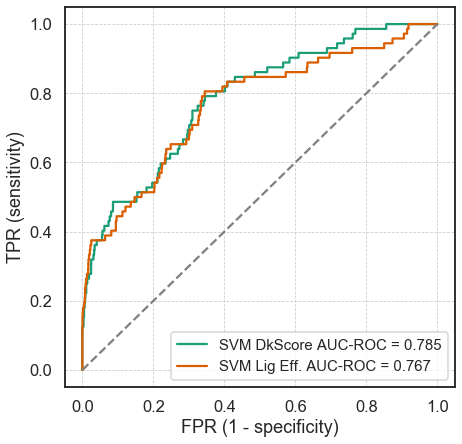

In [96]:
svc_params = {'SVC__gamma': [0.01, 0.1, 1], 'SVC__kernel': ['linear', 'rbf']}

X_train = X_dksc_CSAR; y_train = y_dksc_CSAR
X_test = X_dksc_DUD; y_test = y_dksc_DUD
y_score_dksc, svc_dksc = run_SVM(X_train, X_test, y_train, y_test, kernel='rbf',
                                 extra_params_dict = svc_params)

X_train = X_dkef_CSAR; y_train = y_dkef_CSAR
X_test = X_dkef_DUD; y_test = y_dkef_DUD
y_score_dkef, svc_dkef = run_SVM(X_train, X_test, y_train, y_test, kernel='rbf', 
                                 extra_params_dict = svc_params)

svm_preds = {'SVM DkScore': y_score_dksc, 'SVM Lig Eff.': y_score_dkef}
svm_rocs = PlotMetric(y_true = y_test, y_pred_dict = svm_preds,
                     decreasing = False)
svm_rocs.plot_roc_auc('')

In [97]:
svc_dksc

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.01,
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [98]:
svc_dkef

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.01,
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)